###**ATOC4500 Data Science Lab: Final Project**
###**Determining the Correlation Between ENSO Index and SWE at Berthoud Pass**
###Author: Jacob Frye, jafr1867@colorado.edu###
###last updated: April 26th, 2022###

**>>>> This code is available on github at (insert URL)**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

###**Introduction:** The motivation behind this project is to determine the correlation between the ENSO Index and SWE in Loveland, CO. I am interested to see if a higher ENSO index can be used to predict what the weather will look like in the midwest, due to the change that an ENSO event imparts on the jetstream and precipitation in the US. The data that is used in this project is from usda.gov for SWE, and noaa.gov for ENSO index (the specific links are provided at the bottom of this project, along with the credit of data munging).The null hypothesis of this project is that a stronger El Nino index will result in a greater snowpack due to the increased precipitation from an El Nino event. The motivation is to determine how much of an effect El Nino events have on the weather patterns of the inland United States, and more specifically, the Loveland/Colorado snowpack. Below is the beginning of the five formal steps of formal hypothesis testing, which will be completed at the end of the project:

 **1. State the significance level:** 0.05

 **2. State the null hypothesis (H0):** The true correlation is not zero, the alternative hypothesis is that it is zero.

 **3. State the statistic to be used, and the assumptions:** The Fisher-Z statistic will be used, assuming the data is normalized and standardized.






###**Step 1: Read in data**



Include the fact that snowpack is being measured using the SWE (Snow Water Equivalent), describe what that is, and how it relates to the snowpack directly as a number. Also mention the fact that it is called snowpack throughout the entire project, and SWE is a secondary term for the data. Measured in inches.

In [1]:
### import packages
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import relativedelta
import csv
from scipy import stats
from matplotlib import rcParams
from sklearn import linear_model
from sklearn import metrics
from google.colab import files

### define global function
# function to standardize data
# recall that standardize the data = remove the mean, divide by the standard deviation.  
def standardize(raw_data):
    sample_mean = np.mean(raw_data)
    sample_std = np.std(raw_data)
    standardized_list = []
    for i in raw_data:
        standardized_list.append((i - sample_mean)/sample_std)
    return standardized_list

### General Setup for bootstrapping
%matplotlib inline  
# this enables plotting within notebook

import matplotlib   # library for plotting
import matplotlib.pyplot as plt #  later you will type plt.$COMMAND
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
## upload the file snow_enso_data_1936-2022.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving updated_snow_enso_data_1936-2022.csv to updated_snow_enso_data_1936-2022.csv
User uploaded file "updated_snow_enso_data_1936-2022.csv" with length 1469 bytes


In [3]:
#read in the data
data = pd.read_csv("updated_snow_enso_data_1936-2022.csv")

# Look at the data by printing it
# preview data (also through data.head() & data.tail())
print(data.head())
print(data.tail())


   Year  BerthoudPass_April1SWE_inches  Nino34_anomaly_prevDec
0  1936                           22.5                   -0.04
1  1937                           13.4                    0.63
2  1938                           13.2                    0.22
3  1939                           18.6                   -0.79
4  1940                           14.5                    0.05
    Year  BerthoudPass_April1SWE_inches  Nino34_anomaly_prevDec
82  2018                           14.0                   -0.85
83  2019                           17.0                    0.97
84  2020                           19.1                    0.51
85  2021                           15.6                   -0.98
86  2022                           13.4                   -1.07


In [4]:
## Read in the specific variables and look at their dimensions
snowpack=data['BerthoudPass_April1SWE_inches']
enso=data['Nino34_anomaly_prevDec']
year = np.arange(2022-len(enso),2022,1)
print(len(enso))
print(len(snowpack))
print(enso.head())
print(snowpack.head())
print(year)

87
87
0   -0.04
1    0.63
2    0.22
3   -0.79
4    0.05
Name: Nino34_anomaly_prevDec, dtype: float64
0    22.5
1    13.4
2    13.2
3    18.6
4    14.5
Name: BerthoudPass_April1SWE_inches, dtype: float64
[1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021]


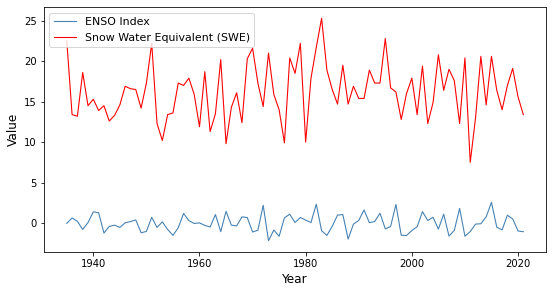

In [5]:
## Make a timeseries plot of the ENSO Index and Snowpack via SWE
fig = plt.figure(figsize=(9,4.5));
plt.plot(year, enso, color='steelblue', lw=1.1,label='ENSO Index');
plt.plot(year, snowpack, color='red', lw=1.1,label='Snow Water Equivalent (SWE)');
plt.xlabel("Year",fontsize=12);
plt.ylabel("Value",fontsize=12);
plt.legend(loc='upper left',fontsize=11);

Here's where the data munging begins. While we are still just getting the first impressions of the data on a graph, it must be detrended and standardized in order to achieve the graph seen below. When the data has been detrended and standardized, they will operate with the same standard deviation and mean, so they can be assessed in the same graphical frame.

In [6]:
### FIRST detrend - i.e., removing the linear slope
slope, intercept, r_value, p_value, std_err = stats.linregress(year,snowpack)
sp_dtrend=snowpack-(year*slope)
print(f'slope: {np.round(slope,2)}')
slope, intercept, r_value, p_value, std_err = stats.linregress(year,enso)
enso_dtrend=enso-(year*slope)
print(f'slope: {np.round(slope,2)}')

## THEN standardize the data (i.e., remove the mean, divide by the standard deviation)
sp_dtrend_stand = standardize(sp_dtrend)
enso_dtrend_stand = standardize(enso_dtrend)

## check that your data have a mean of 0 and a standard deviation of 1
print(f'mean t: {np.round(np.mean(sp_dtrend_stand),1)}')
print(f'mean enso: {np.round(np.mean(enso_dtrend_stand),1)}')
print(f'std t: {np.round(np.std(sp_dtrend_stand),1)}')
print(f'std enso: {np.round(np.std(enso_dtrend_stand),1)}')

slope: 0.02
slope: 0.0
mean t: -0.0
mean enso: -0.0
std t: 1.0
std enso: 1.0


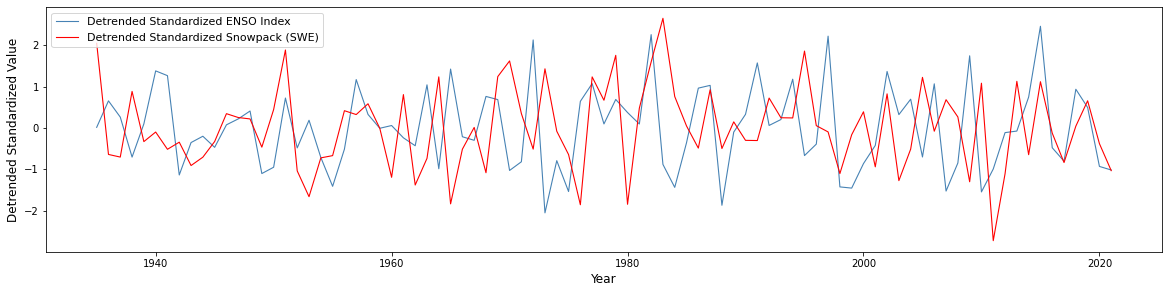

In [7]:
## Make a timeseries plot of standardized/detrended values of ENSO and detrended snowpack
fig = plt.figure(figsize=(20,4.5));
plt.plot(year, enso_dtrend_stand, color='steelblue', lw=1.1,label='Detrended Standardized ENSO Index');
plt.plot(year, sp_dtrend_stand, color='red', lw=1.1,label='Detrended Standardized Snowpack (SWE)');
plt.xlabel("Year",fontsize=12);
plt.ylabel("Detrended Standardized Value",fontsize=12);
plt.legend(loc='upper left',fontsize=11);

As we can see, this data both looks much better and more usable than the graph above, proving why this data needed to be detrended and standardized. With this newly munged data, we can begin the data science process. We begin by creating a scatterplot of our data points correlated with one another, since the point is to determine if the ENSO index is any indication of SWE amount at Loveland, CO. 

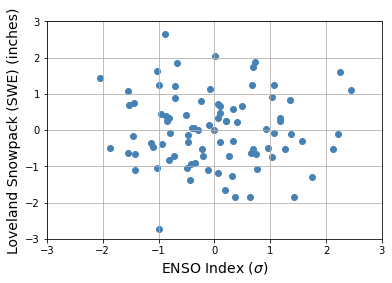

In [8]:
#create a scatterplot of detrended standardized snowpack (on the y axis) and ENSO index (x axis)

fig = plt.figure(figsize=(6,4));
plt.scatter(enso_dtrend_stand,sp_dtrend_stand,c='steelblue');
plt.xlabel("ENSO Index ($\sigma$)",fontsize=14);
plt.ylabel("Loveland Snowpack (SWE) (inches)",fontsize=14);
plt.xlim((-3,3));
plt.ylim((-3,3));
plt.grid();

In [9]:
### Use linear regression to calculate the slope, y-intercept, r-value, and variance explained.

xdata=np.array(enso_dtrend_stand)
ydata=np.array(sp_dtrend_stand)
variancex=np.sum((xdata*xdata))
covariance=np.dot(xdata,ydata)
slope=covariance/variancex ##Barnes Chapter 2, Eq. (14)
intercept=np.mean(ydata)-slope*np.mean(xdata)  ##Barnes Chapter 2, Eq. (15)
variancey=np.sum((ydata*ydata))
r_value=covariance/(np.sqrt(variancex)*np.sqrt(variancey)) ##Barnes Chapter 2, Eq. (31)
print('RESULTS - "from scratch"')
print('Slope, a1 (standard deviation Snowpack (SWE)/standard deviation ENSO index):',round(slope,2))
print('Intercept, a0 (standard deviation Snowpack):', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
print('\n')

print('RESULTS - "using stats.linregress"')
slope, intercept, r_value, p_value, std_err = stats.linregress(enso_dtrend_stand,sp_dtrend_stand)
print('Slope, a1 (standard deviation Snowpack (SWE)/standard deviation ENSO index):',round(slope,2))
print('Intercept, a0 (standard deviation Snowpack):', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')

RESULTS - "from scratch"
Slope, a1 (standard deviation Snowpack (SWE)/standard deviation ENSO index): -0.03
Intercept, a0 (standard deviation Snowpack): -0.0
R_Value: -0.03
Percent variance explained: 0.1 %


RESULTS - "using stats.linregress"
Slope, a1 (standard deviation Snowpack (SWE)/standard deviation ENSO index): -0.03
Intercept, a0 (standard deviation Snowpack): -0.0
R_Value: -0.03
Percent variance explained: 0.1 %


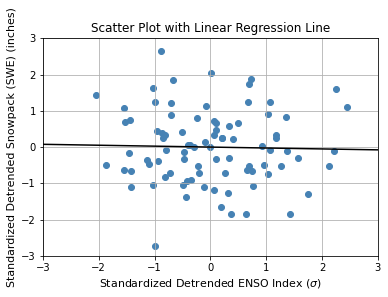

In [10]:
### Remake the scatter plot and include the Linear Regression Prediction Line (i.e., the line that represents
### the estimate of y. given x based on linear regression)
fit_x = np.arange(-4,4.1,0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)
plt.scatter(enso_dtrend_stand,sp_dtrend_stand,c='steelblue');
plt.xlabel("Standardized Detrended ENSO Index ($\sigma$)",fontsize=11);
plt.ylabel("Standardized Detrended Snowpack (SWE) (inches)",fontsize=11);
plt.xlim((-3,3));
plt.ylim((-3,3));
plt.grid();
plt.title("Scatter Plot with Linear Regression Line",fontsize=12);
plt.plot(fit_x,fit_y,c='black');

Here, the line of best fit is plotted over the same scatterplot from before, using linear regression to calculate slope, y-intercept, r-value, and variance for the data. We see that the line is slightly negative, which indicates that the data is negatively correlated. The slope is also very shallow, which means that there is not a strong trend in any one direction, indicating that the correlation is not very strong either. 

In [12]:
### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=len(year)
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

### Method #2: H0 (null hypothesis) true correlation is not 0.

## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('')
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(year)
df=N-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))
print('')
## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))
print('')
## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))
print('')
print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 85
tcrit= 1.99
t= -0.23
Since t= -0.23 does not exceed tcrit= 1.99  we cannot reject the null hypothesis

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: -0.03
sigma_Z: 0.11

tstat95 1.989
Zmin (minimum 95% confidence interval) -0.24
Zmax (maximum 95% confidence interval) 0.19

Rhomin (minimum 95% confidence interval for true r_value): -0.24
Rhomax (maximum 95% confidence interval for true r_value): 0.19

If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


Here is where we use two different methods to confirm what the linear regression told us in the previous blocks of code: that the data is barely negatively correlated. These two methods agree. In method 1, being unable to reject the null hypothesis that the true correlation is zero actually says that we are accepting that null hypothesis. In method 2, rejecting the null hypothesis that the true correlation is **not** zero means that we must accept the null hypothesis that the correlation **IS** zero. These results are more absolute than what the linear regression showed us, and so we will build our conclusion off of these results instead. We will now test using N* values to further unify the data, and calculate the correlation of the data using the same "memory frame" for each data point.

In [13]:
#For the snowpack
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=sp_dtrend_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'Snowpack autocorrelation:',round(alpha,3))
## calculate N*
sp_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',sp_nstar) 

#For the ENSO index
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
tseries1=enso_dtrend_stand
n=len(tseries1)
sigma=1
lag=1
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('')
print('lag',lag,'ENSO autocorrelation:',round(alpha,3))
## calculate N*
enso_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('#independent samples, N*: ',enso_nstar) 

lag 1 Snowpack autocorrelation: -0.047
#independent samples, N*:  79.0

lag 1 ENSO autocorrelation: -0.091
#independent samples, N*:  73.0


In [14]:
##Re-Assessing the statistical significance of the correlation using N* instead of N

## here we will be conservative and use the smaller of the two N* values
Nstar=min(sp_nstar,enso_nstar)
print('N* Variable')
print(Nstar)
print('')

### Method #1: H0 (null hypothesis) correlation is 0  ## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero. ')
N=Nstar
dof=N-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis')

## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('')
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(year)
df=N-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))

## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))

print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

N* Variable
73.0

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero. 
dof 71.0
tcrit= 1.99
t= -0.21
Since t= -0.21 does not exceed tcrit= 1.99  we cannot reject the null hypothesis

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: -0.03
sigma_Z: 0.11
tstat95 1.989
Zmin (minimum 95% confidence interval) -0.24
Zmax (maximum 95% confidence interval) 0.19
Rhomin (minimum 95% confidence interval for true r_value): -0.24
Rhomax (maximum 95% confidence interval for true r_value): 0.19
If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


The N* method has once again reinforced what has already been shown to us. Methods 1 and 2 agree again. The next bit of code will be bootstrapping the data to check the hypotheses again using data that has been randomly created using the same parameters. Bootstrapping will show the other possibilities for the results of this data, and give us results from "ideal" data that has been created from scratch. 

In [16]:
# Double checking the columns and data before bootstrapping
### Print the data column names
print(data.columns[0])
print(data.columns[1])
print(data.columns[2])
print('')
print(data['Year'].values)
print(data['BerthoudPass_April1SWE_inches'].values)
print(data['Nino34_anomaly_prevDec'].values)

Year
BerthoudPass_April1SWE_inches
Nino34_anomaly_prevDec

[1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022]
[22.5 13.4 13.2 18.6 14.5 15.3 13.9 14.5 12.6 13.3 14.6 16.9 16.6 16.5
 14.2 17.3 22.2 12.3 10.2 13.4 13.6 17.3 17.  17.9 15.9 11.9 18.7 11.3
 13.5 20.2  9.8 14.3 16.1 12.4 20.3 21.6 17.3 14.4 21.  15.9 14.   9.9
 20.4 18.5 22.2 10.  17.9 21.7 25.3 18.9 16.5 14.7 19.5 14.7 16.9 15.4
 15.4 18.9 17.3 17.3 22.8 16.7 16.2 12.8 16.  17.9 13.4 19.4 12.3 14.9
 20.8 16.4 19.  17.6 12.3 20.4  7.5 13.  20.6 14.6 20.6 16.4 14.  17.
 19.1 15.6 13.4]
[-0.04  0.63  0.22 -0.79  0.05  1.39  1.27 -1.24 -0.42 -

In [20]:
### Calculate the average snowfall  at Berthoud Pass, Colorado
SWE_avg=data['BerthoudPass_April1SWE_inches'].mean()
SWE_std=data['BerthoudPass_April1SWE_inches'].std()
N_SWE=len(data.BerthoudPass_April1SWE_inches)
print('Average SWE (inches):',str(np.round(SWE_avg,2)))
print('Standard Deviation SWE (inches):',str(np.round(SWE_std,2)))
print('N:',str(N_SWE))

Average SWE (inches): 16.24
Standard Deviation SWE (inches): 3.43
N: 87


In [25]:
### Calculate the average SWE when it was an el nino year
print('Average SWE during an El Nino Year:')
SWE_avg_nino=data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nino=data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nino=len(data[data.Nino34_anomaly_prevDec>1.0].BerthoudPass_April1SWE_inches)
print('Average SWE El Nino (inches):',str(np.round(SWE_avg_nino,2)))
print('Standard Deviation SWE El Nino (inches):',str(np.round(SWE_std_nino,2)))
print('N El Nino:',str(N_SWE_nino))

print('')

### Calculate the average SWE when it was an la nina year
print('Average SWE during a La Nina Year:')
SWE_avg_nina=data[data.Nino34_anomaly_prevDec<-1.0]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nina=data[data.Nino34_anomaly_prevDec<-1.0]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nina=len(data[data.Nino34_anomaly_prevDec<-1.0].BerthoudPass_April1SWE_inches)
print('Average SWE La Nina (inches):',str(np.round(SWE_avg_nina,2)))
print('Standard Deviation SWE La Nina (inches):',str(np.round(SWE_std_nina,2)))
print('N La Nina:',str(N_SWE_nina))

Average SWE during an El Nino Year:
Average SWE El Nino (inches): 16.44
Standard Deviation SWE El Nino (inches): 3.29
N El Nino: 16

Average SWE during a La Nina Year:
Average SWE La Nina (inches): 16.19
Standard Deviation SWE La Nina (inches): 3.81
N La Nina: 16


In [28]:
### Bootstrap!!  Generate random samples of size N_SWE_nino and N_SWE_nina.  Do it once to see if it works.
P_random=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)
print(P_random)  ## LOOK AT YOUR DATA

[20.6 16.2 25.3 17.  10.  12.8 17.9 17.3 15.3 20.4 18.5 17.6 13.5 17.3
 11.9 20.8]


In [30]:
### Now Bootstrap Nbs times to generate a distribution of randomly selected mean SWE.
Nbs=1000
## initialize array
P_Bootstrap=np.empty((Nbs,N_SWE_nino))
## loop over to fill in array with randomly selected values
for ii in range(Nbs):
    P_Bootstrap[ii,:]=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)

## Calculate the means of your randomly selected SWE values.
P_Bootstrap_mean=np.mean(P_Bootstrap,axis=1)
print(len(P_Bootstrap_mean))  ## check length to see if you averaged across the correct axis
print(np.shape(P_Bootstrap_mean)) ## another option to look at the dimensions of a variable

P_Bootstrap_mean_avg=np.mean(P_Bootstrap_mean)
print(P_Bootstrap_mean_avg)
P_Bootstrap_mean_std=np.std(P_Bootstrap_mean)
print(P_Bootstrap_mean_std)
P_Bootstrap_mean_min=np.min(P_Bootstrap_mean)
print(P_Bootstrap_mean_min)
P_Bootstrap_mean_max=np.max(P_Bootstrap_mean)
print(P_Bootstrap_mean_max)


1000
(1000,)
16.2400375
0.8490117684512684
13.3
18.78125


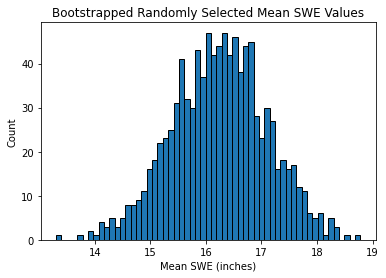

In [32]:
### Use matplotlib to plot a histogram of the bootstrapped means to compare to the conditioned SWE mean
binsize=0.1
min4hist=np.round(np.min(P_Bootstrap_mean),1)-binsize
max4hist=np.round(np.max(P_Bootstrap_mean),1)+binsize
nbins=int((max4hist-min4hist)/binsize)

plt.hist(P_Bootstrap_mean,nbins,edgecolor='black')
plt.xlabel('Mean SWE (inches)');
plt.ylabel('Count');
plt.title('Bootstrapped Randomly Selected Mean SWE Values');

In [37]:
## What is the probability that the snowfall was lower during El Nino by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd
print("sample_mean - El Nino: ",str(np.round(sample_mean,2)))
print("population_mean: ",str(np.round(population_mean,2)))
print("population_std: ",str(np.round(population_std,2)))
print("Z-statistic (number of standard errors that the sample mean deviates from the population mean:")
print(np.round(z_nino,2))
prob=(1-stats.norm.cdf(np.abs(z_nino)))*100 ##this is a one-sided test
print("Probability one-tailed test (percent):")
print(np.round(prob,2)) 

sample_mean - El Nino:  16.44
population_mean:  16.24
population_std:  0.85
Z-statistic (number of standard errors that the sample mean deviates from the population mean:
0.24
Probability one-tailed test (percent):
40.52


In [38]:
## What is the probability that the snowfall that the El Nino mean differs from the mean by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd
print("sample_mean - El Nino: ",str(np.round(sample_mean,2)))
print("population_mean: ",str(np.round(population_mean,2)))
print("population_std: ",str(np.round(population_std,2)))
print("Z-statistic (number of standard errors that the sample mean deviates from the population mean):")
print(np.round(z_nino,2))
prob=(1-stats.norm.cdf(np.abs(z_nino)))*2*100 ##this is a two-sided test
print("Probability - two-tailed test (percent):")
print(np.round(prob,2)) 

sample_mean - El Nino:  16.44
population_mean:  16.24
population_std:  0.85
Z-statistic (number of standard errors that the sample mean deviates from the population mean):
0.24
Probability - two-tailed test (percent):
81.04


In [39]:
## What is the probability that the snowfall was higher during La Nina just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print("sample_mean - La Nina: ",str(np.round(sample_mean,2)))
print("population_mean: ",str(np.round(population_mean,2)))
print("population_std: ",str(np.round(population_std,2)))
print("Z-statistic (number of standard errors that the sample mean deviates from the population mean:")
print(np.round(z_nina,2))
prob=(1-stats.norm.cdf(np.abs(z_nina)))*100 ##this is a one-sided test
print("Probability one-tailed test (percent):")
print(np.round(prob,2)) 

sample_mean - La Nina:  16.19
population_mean:  16.24
population_std:  0.85
Z-statistic (number of standard errors that the sample mean deviates from the population mean:
-0.05
Probability one-tailed test (percent):
47.83


In [40]:
## What is the probability that the snowfall during La Nina differed just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print("sample_mean - La Nina: ",str(np.round(sample_mean,2)))
print("population_mean: ",str(np.round(population_mean,2)))
print("population_std: ",str(np.round(population_std,2)))
print("Z-statistic (number of standard errors that the sample mean deviates from the population mean):")
print(np.round(z_nina,2))
prob=(1-stats.norm.cdf(np.abs(z_nina)))*2*100 ##this is a two-sided test
print("Probability - two-tailed test (percent):")
print(np.round(prob,2)) 

sample_mean - La Nina:  16.19
population_mean:  16.24
population_std:  0.85
Z-statistic (number of standard errors that the sample mean deviates from the population mean):
-0.05
Probability - two-tailed test (percent):
95.65


As we can see from the two tests that ask if snowfall differed just due to chance, during either an El Nino or La Nina, the chances are 81 and 95 percent, respectively. Taking this information in conjunction with the fact that the two tests that asked if snowfall was lower during an El Nino or higher during a La Nina, which resulted in 40 and 47 percent, we can safely assume that there is not a distribution that is favored more than the other. Because neither of the amount statistics indicate a preference, and the difference from the mean was much, much higher, it shows that there is very little correlation between the ENSO index and the Berthoud Pass SWE amount. 

In [41]:
### Strategy #2:  Forget bootstrapping, let's use a t-test...
## Apply a t-test to test the null hypothesis that the means of the two samples 
## are the same at the 95% confidence level (alpha=0.025, two-sided test)
## If pvalue < alpha - reject null hypothesis.
print('Null Hypothesis:  ENSO snow years have the same mean as the full record.')
stats.ttest_ind(data['BerthoudPass_April1SWE_inches'],data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'])
print(stats.ttest_ind(data['BerthoudPass_April1SWE_inches'],data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches']))
print('Cannot reject the null hypthesis.')

Null Hypothesis:  ENSO snow years have the same mean as the full record.
Ttest_indResult(statistic=-0.2241669047356888, pvalue=0.8230802767549563)
Cannot reject the null hypthesis.


This reinforces the statement we made from the bootstrapping. We cannot reject the null hypothesis that the ENSO snow years have the same mean as the full record, which means that we must accept the fact that ENSO snow years are not statistically remarkable from the rest of the data set. Now, we will reuse some of the code from above that created graphs to represent the data to restate claims, and support the conclusion.

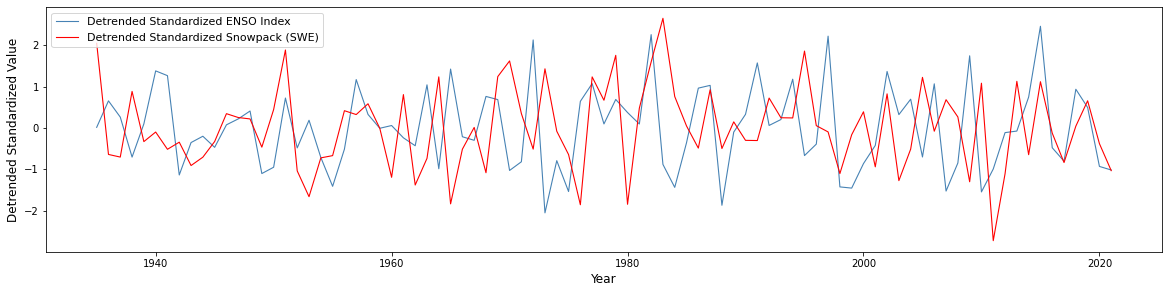

In [42]:
fig = plt.figure(figsize=(20,4.5));
plt.plot(year, enso_dtrend_stand, color='steelblue', lw=1.1,label='Detrended Standardized ENSO Index');
plt.plot(year, sp_dtrend_stand, color='red', lw=1.1,label='Detrended Standardized Snowpack (SWE)');
plt.xlabel("Year",fontsize=12);
plt.ylabel("Detrended Standardized Value",fontsize=12);
plt.legend(loc='upper left',fontsize=11);

This is the first graph of any significance in this project. While it is not exhaustive, a quick glance seems to indicate that there could be some correlation between ENSO values and SWE at Berthoud Pass, since the peaks and valleys generally seem to align. The further data science is done with the intent of uncovering that correlation (or lack thereof).

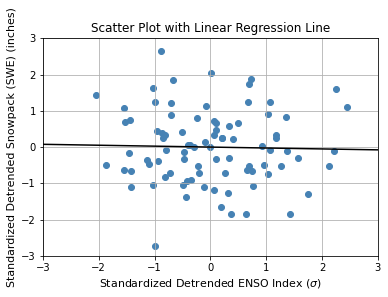

In [43]:
fit_x = np.arange(-4,4.1,0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)
plt.scatter(enso_dtrend_stand,sp_dtrend_stand,c='steelblue');
plt.xlabel("Standardized Detrended ENSO Index ($\sigma$)",fontsize=11);
plt.ylabel("Standardized Detrended Snowpack (SWE) (inches)",fontsize=11);
plt.xlim((-3,3));
plt.ylim((-3,3));
plt.grid();
plt.title("Scatter Plot with Linear Regression Line",fontsize=12);
plt.plot(fit_x,fit_y,c='black');

This scatterplot, with the line of linear regression plotted over it, is the first big piece of evidence that goes against my hypothesis. Since the line is incredibly shallow, it indicates that the correlation between these data is negligible, and since it is negative, it tells that the correlation itself is negative - any correlation that exists would indicate that as ENSO indices become more positive, the SWE (in inches) is ever so slightly smaller.

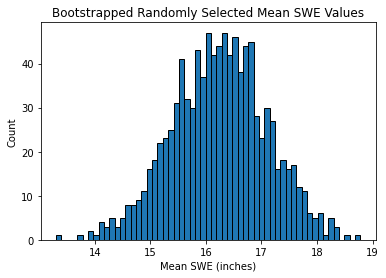

In [44]:
binsize=0.1
min4hist=np.round(np.min(P_Bootstrap_mean),1)-binsize
max4hist=np.round(np.max(P_Bootstrap_mean),1)+binsize
nbins=int((max4hist-min4hist)/binsize)

plt.hist(P_Bootstrap_mean,nbins,edgecolor='black')
plt.xlabel('Mean SWE (inches)');
plt.ylabel('Count');
plt.title('Bootstrapped Randomly Selected Mean SWE Values');

This histogram, which is created using the bootstrapped values, shows that even with "artificially created" data, the mean SWE still resides between the calculated values of 16.19 and 16.44 during La Nina and El Nino, respectively. This demonstrates that the majority of the data does not indicate a preference around either La Nina or El Nino, further cementing the idea that these data are not correlated. 

Here is the final assessment of the statistical significance of all the data science that has been done here, including the 5 formal steps of hypothesis testing. 

 **1. State the significance level:** 0.05

 **2. State the null hypothesis (H0):** The true correlation is not zero, the alternative hypothesis is that it is zero.

 **3. State the statistic to be used, and the assumptions:** The Fisher-Z statistic will be used, assuming the data is normalized and standardized.

 **4. State the critical region:** The critical region is -0.24 to 0.19.

 **5. Evaluate the statistic and state the conclusion (code provided above):** The confidence bounds do include 0, so we must reject the null hypothesis is not 0 and accept the alternative hypothesis that it is 0.

This project demonstrated that there is no significant correlation between the ENSO index and SWE at Berthoud Pass in Loveland, CO. This is interesting to me, because my knowledge of how the mid-latitude jetstream and subsequent precipitation shift during an El Nino event, and I would have thought that there would be more of a correlation between the two. Further research would include snowpack data from across the United States, along the same latitude line, to see where (if anywhere), the change in precipitation from an El Nino event is recorded in a change of SWE. This project definitely had a surprising result, and discovering that there was not much of a correlation drove me to do these different kinds of data science methods to reinforce the conclusion that was reached. In conclusion, ENSO data cannot be used to predict SWE at Berthoud Pass in Loveland pass because they are not positively correlated, and are negligibly negatively correlated. The variance in SWE at Berthoud Pass is not explained by the ENSO index because the variables are not associated with one another. 

The SWE data is from these websites:

https://www.nrcs.usda.gov/wps/portal/wcc/home/snowClimateMonitoring/

https://wcc.sc.egov.usda.gov/nwcc/rgrpt?report=snowmonth_hist&state=CO

The ENSO Index data is from this website:

 https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/

 The data were put into an excel sheet that was created by Professor Jen Kay at the University of Colorado Boulder, and then modified by Jacob Frye, an undergraduate at the University of Colorado Boulder in her class.